In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!pip install transformers -qq
!pip install sentencepiece -qq
!pip install tokenizer -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/ProcessingData/train.csv')
dev = pd.read_csv('/content/drive/MyDrive/ProcessingData/val.csv')
test = pd.read_csv('/content/drive/MyDrive/ProcessingData/test.csv')


train['Comment'] = train['Comment'].astype(str)
X_train = train['Comment']
y_train = train["Label"]

dev['Comment'] = dev['Comment'].astype(str)
X_valid = dev['Comment']
y_valid = dev['Label']

test['Comment'] = test['Comment'].astype(str)
X_test = test['Comment']
y_test = test['Label']

In [4]:

import torch
from torchtext import data
from torchtext import datasets
import random
import numpy as np

SEED = 8

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

torch.cuda.is_available()

True

In [5]:
import pandas as pd
from glob import glob

train_sentences = list(train['Comment'].values)
train_labels = list(train['Label'].values)

dev_sentences = list(dev['Comment'].values)
dev_labels = list(dev['Label'].values)

test_sentences = list(test['Comment'].values)
test_labels = list(test['Label'].values)

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
#choose max_length for phobert model based on the input length

max_length = 0
list_len=[]
for sentence in train_sentences:
    length = len(tokenizer.tokenize(sentence))
    list_len.append(length)

from collections import Counter
Counter(list_len).most_common(100)


[(3, 856),
 (4, 769),
 (2, 752),
 (5, 682),
 (1, 580),
 (6, 541),
 (7, 394),
 (8, 289),
 (9, 199),
 (10, 170),
 (11, 100),
 (12, 80),
 (13, 51),
 (14, 47),
 (15, 31),
 (16, 18),
 (19, 17),
 (17, 16),
 (20, 11),
 (18, 11),
 (24, 9),
 (22, 7),
 (27, 6),
 (21, 5),
 (30, 4),
 (23, 4),
 (26, 3),
 (32, 2),
 (35, 2),
 (34, 1),
 (25, 1),
 (39, 1),
 (29, 1),
 (31, 1),
 (37, 1),
 (46, 1),
 (28, 1),
 (33, 1)]

In [8]:
# Encode train label

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_labels)
encoded_labels = le.transform(train_labels)
encoded_test_labels = le.transform(dev_labels)

In [9]:
# Tokens IDs tensor

def encoder_generator(sentences,labels):

    sent_index = []
    input_ids = []
    attention_masks =[]

    for index,sent in enumerate(sentences):

        sent_index.append(index)

        encoded_dict = tokenizer.encode_plus(sent,
                                             add_special_tokens=True,
                                             max_length=20,
                                             pad_to_max_length=True,
                                             truncation = True,
                                             return_attention_mask=True,
                                             return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids,dim=0).cuda()
    attention_masks = torch.cat(attention_masks,dim=0).cuda()
    labels = torch.tensor(labels).cuda()
    sent_index = torch.tensor(sent_index).cuda()

    return sent_index,input_ids,attention_masks,labels

train_sent_index,train_input_ids,train_attention_masks,train_encoded_label_tensors = encoder_generator(train_sentences,encoded_labels)
dev_sent_index,dev_input_ids,dev_attention_masks,dev_encoded_label_tensors = encoder_generator(dev_sentences,encoded_test_labels)
print('Original: ', train_sentences[0])
print('Token IDs:', train_input_ids[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  giàu vãi cả lồn
Token IDs: tensor([    0,  1436, 31827,    94,  1494,  5460,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       device='cuda:0')


In [10]:
# Connvert train, dev input by using TensorDataset

from torch.utils.data import TensorDataset,random_split

train_dataset = TensorDataset(train_input_ids,train_attention_masks,train_encoded_label_tensors)
dev_dataset = TensorDataset(dev_input_ids,dev_attention_masks,dev_encoded_label_tensors)

print('train data samples is {}'.format(len(train_dataset)))
print("valid data samples is {}".format(len(dev_dataset)))

train data samples is 5665
valid data samples is 809


In [11]:
# Set cuda by using device

from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

bs=128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_loader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=bs)
valid_data_loader = DataLoader(dev_dataset,
                              sampler=RandomSampler(dev_dataset),
                              batch_size=bs)

In [12]:
from transformers import AutoModel

phoBert = AutoModel.from_pretrained('vinai/phobert-base')
phoBert = phoBert.to(device)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# Build class CNN

import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):

        super().__init__()

        self.fc_input = nn.Linear(embedding_dim,embedding_dim)

        self.conv_0 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[0])

        self.conv_1 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[1])

        self.conv_2 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[2])

        self.conv_3 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[3])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, encoded):

        #embedded = [batch size, sent len, emb dim]
        embedded = self.fc_input(encoded)
        #print(embedded.shape)

        embedded = embedded.permute(0, 2, 1)
        #print(embedded.shape)

        #embedded = [batch size, emb dim, sent len]

        conved_0 = F.relu(self.conv_0(embedded))
        conved_1 = F.relu(self.conv_1(embedded))
        conved_2 = F.relu(self.conv_2(embedded))
        conved_3 = F.relu(self.conv_3(embedded))

        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        pooled_3 = F.max_pool1d(conved_3, conved_3.shape[2]).squeeze(2)

        #pooled_n = [batch size, n_fibatlters]

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2, pooled_3), dim = 1).cuda())

        #cat = [batch size, n_filters * len(filter_sizes)]

        result =  self.fc(cat)

        #print(result.shape)

        return result

In [14]:
# Hyperparameters

EMBEDDING_DIM = 768
N_FILTERS = 32
FILTER_SIZES = [1,2,3,5]
OUTPUT_DIM = len(le.classes_)
DROPOUT = 0.1
PAD_IDX = tokenizer.pad_token_id

cnn = CNN(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
cnn = cnn.to(device)


In [155]:
# Optimizer and criterion

import torch.optim as optim

model_prameters = list(phoBert.parameters())+list(cnn.parameters())

optimizer = optim.Adam(model_prameters,lr=1e-5,eps=1e-9)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [156]:
# Calculate accuracy per batch during train

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).cuda()

In [157]:
# Def for training

from tqdm import tqdm

def train():

    epoch_loss = 0
    epoch_acc = 0

    phoBert.train()
    cnn.train()

    for batch in tqdm(train_data_loader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()

        embedded = phoBert(b_input_ids,b_input_mask)[0]

        predictions = cnn(embedded)

        loss = criterion(predictions, b_labels)

        acc = categorical_accuracy(predictions, b_labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_data_loader), epoch_acc / len(train_data_loader)

In [158]:
# Class for predict label

import numpy as np

def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

In [159]:
# Evaluate loss, acc  and f1-macro

from sklearn.metrics import classification_report,accuracy_score,f1_score, confusion_matrix
def eval():
    epoch_loss = 0

    total_predictions = []
    total_true = []

    all_true_labels = []
    all_pred_labels = []

    phoBert.eval()
    cnn.eval()

    with torch.no_grad():

        for batch in tqdm(valid_data_loader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            embedded = phoBert(b_input_ids,b_input_mask)[0]
            predictions = cnn(embedded)

            loss = criterion(predictions, b_labels)
            epoch_loss += loss.item()

            predictions = predictions.detach().cpu().numpy()

            Labels = b_labels.to('cpu').numpy()

            pred,true = predictions_labels(predictions,Labels)

            all_pred_labels.extend(pred)
            all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    macro_f1_score = f1_score(all_pred_labels,all_true_labels,average='macro')

    avg_val_loss = epoch_loss/len(valid_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))

    return avg_val_loss,avg_val_accuracy,macro_f1_score

In [160]:
# Time for training

import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [161]:
# Set device and gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

phoBert.cuda()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [162]:
epochs = 20

best_macro_f1 = float('0')

for epoch in range(epochs):

    start_time = time.time()
    train_loss,train_acc = train()
    valid_loss,valid_acc,macro_f1 = eval()
    end_time = time.time()


    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        torch.save(phoBert,'/content/drive/MyDrive/PhoBERT-CNN/phobert_cnn_model_part1_'+'task2a_2.pt')
        torch.save(cnn,'/content/drive/MyDrive/PhoBERT-CNN/phobert_cnn_model_part2_'+'task2a_2.pt')
        print("model saved")

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. acc: {valid_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {macro_f1*100:.2f}%')
    print('=============Epoch Ended==============')

  0%|          | 0/45 [00:00<?, ?it/s]


OutOfMemoryError: ignored

In [ ]:
# Save PhoBERT and CNN

torch.save(phoBert,'/content/drive/MyDrive/PhoBERT-CNN/module2_part1.pt')
torch.save(cnn,'/content/drive/MyDrive/PhoBERT-CNN/module2_part2.pt')

In [164]:

# Load phobert and cnn

import torch
phoBert = torch.load(r'/content/drive/MyDrive/PhoBERT-CNN/phobert_cnn_model_part1_task2a_2.pt')
cnn = torch.load(r'/content/drive/MyDrive/PhoBERT-CNN/phobert_cnn_model_part2_task2a_2.pt')
phoBert.eval()
cnn.eval()


OutOfMemoryError: ignored

In [ ]:
test_sent_index, test_input_ids, test_attention_masks, test_encoded_label_tensors = encoder_generator(test_sentences,test_labels)
test_dataset = TensorDataset(test_input_ids,test_attention_masks,test_encoded_label_tensors)

test_data_loader = DataLoader(test_dataset,
                              sampler=RandomSampler(test_dataset),
                              batch_size=bs)

all_pred_labels = []
all_true_labels = []

with torch.no_grad():
  for batch in tqdm(test_data_loader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    embedded = phoBert(b_input_ids,b_input_mask)[0]
    predictions = cnn(embedded)


    predictions = predictions.detach().cpu().numpy()

    Labels = b_labels.to('cpu').numpy()

    pred, true = predictions_labels(predictions, Labels)

    all_pred_labels.extend(pred)
    all_true_labels.extend(true)

In [ ]:
# The final score in the test set (classification report)

print(classification_report(all_pred_labels,all_true_labels, digits = 4))

In [165]:
evaluation = f1_score(all_true_labels, all_pred_labels, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(all_true_labels, all_pred_labels, average='macro')
print("F1 - macro: " + str(evaluation))

F1 - micro: 0.8943792464484249
F1 - macro: 0.7438136495536369


<Axes: >

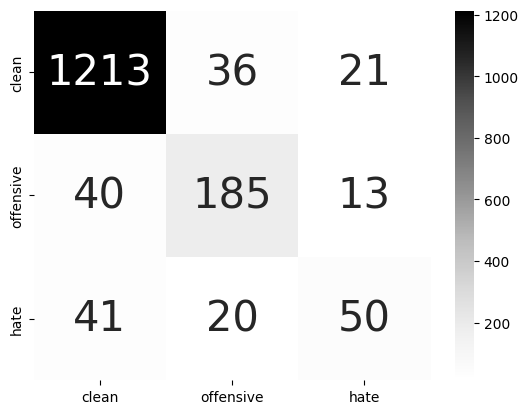

In [163]:
import matplotlib.pyplot as plt
import seaborn as sn
cf1 = confusion_matrix(all_true_labels, all_pred_labels)
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})